In [1]:
import pmx
from pmx.utils import create_folder
from pmx import gmx, ligand_alchemy, jobscript
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%pylab inline
from IPython.core.display import clear_output
import os,shutil
import re
import subprocess
import glob
import random
import pandas as pd
import importlib
if 'AZtutorial' in sys.modules:
    importlib.reload(sys.modules['AZtutorial'])
else:
    import AZtutorial
from AZtutorial import *
from IPython.display import Image


from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, rdmolfiles, rdMolAlign, rdmolops, rdchem, PyMol, Crippen, PropertyMol
from rdkit import DataStructs
from rdkit import RDLogger

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D
from rdkit.Numerics.rdAlignment import GetAlignmentTransform
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdMolTransforms
from tqdm import tqdm
from copy import deepcopy

try:
    import cPickle as pickle
except:
    import pickle
import os
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull


@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

Populating the interactive namespace from numpy and matplotlib


# Step -3. Set up paths for the workflow

In [2]:

# initialize the free energy environment object: it will store the main parameters for the calculations
fe = AZtutorial( )

# set the workpath
fe.workPath = 'workpath'
# set the path to the molecular dynamics parameter files
fe.mdpPath = 'input/mdppath'
# set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
fe.replicas = 3
# provide the path to the protein structure and topology
fe.proteinPath = 'input/protein_amber'
# provide the path to the folder with ligand structures and topologies
fe.ligandPath = 'input/ligands'


os.environ['GMXLIB'] = "/home/ykhalak/private/gmx_share_top_w_new_vdwradii"

In [3]:
! echo $GMXLIB

/home/ykhalak/private/gmx_share_top_w_new_vdwradii


In [4]:
! which gmx

/usr/local/gromacs/2021/2021-impi2017-fftw337-gcc93-cuda11.1-fix3943/bin/gmx


# Step -2. Select ligands

In [5]:
training_ligand_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket_4d09_protein/processed_69_cl13_ligs_in_4d09_for_ddG_calc.pickle"
with open(training_ligand_databse_fn, 'rb') as f:
    training_ligs = pickle.load(f)

reference_lig_name="JAN_PDE2_1345"
for i,l in enumerate(training_ligs):
    if(reference_lig_name in l.GetProp("ID")):
        print(i)
        reference_lig_id=i
        
reference_lig=training_ligs[reference_lig_id]

del training_ligand_databse_fn,training_ligs
import gc
gc.collect()

54


0

In [6]:
folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{folder}/morphing_annealing_4d09_filtered_subset/"

with open(pocket_fit_folder+"/step_4_picks.pickle", 'rb') as f:
    test_ligs = pickle.load(f)

In [ ]:
Draw.MolsToGridImage(test_ligs+[reference_lig],
                     legends=[l.GetProp("ID") for l in test_ligs+[reference_lig]],
                     subImgSize = (400,400), molsPerRow=5, maxMols=101)

# Step -1. Properly parametrize ligands

In [13]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
    mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
    mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
    
    mol_pdb=f"{mol_folder}/mol_gmx.pdb"
    if(not os.path.exists(mol_pdb)):
        with open(mol_pdb,"w") as f:
            f.write(rdmolfiles.MolToPDBBlock(mol))
            
    mol_itp=mol_folder+"/MOL.acpype/MOL_GMX.itp"
    if(not os.path.exists(mol_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        mol_file = "MOL.mol"
        process = subprocess.Popen(['acpype', '-i', mol_file, '-a', 'gaff', '-c', 'bcc', '-b', "MOL", '-n', repr(totQ)],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE)
        process.wait()
#         out=process.stdout.read().decode("utf-8")
#         err=process.stderr.read().decode("utf-8")
#         print(out)
#         print(err)

        os.system("sed '/\\[ moleculetype \\]/Q' MOL.acpype/MOL_GMX.itp > ffMOL.itp 2>&1")
        os.system("sed -n '/\\[ moleculetype \\]/,$p' MOL.acpype/MOL_GMX.itp > MOL.itp  2>&1")

#         #make sigmahole versions
#         os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
#                   " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
#                   " -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
        mp_lock.acquire()
        if(not os.path.exists(mol_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
        mp_lock.release()
#         break;
    else:
        mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
        mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])

print("Now the pool is closed and no longer available")

set4_190810 	 starting in process 26391
set4_188327 	 starting in process 26392
set4_71635 	 starting in process 26393
set4_122493 	 starting in process 26394
set4_188327 	 previously done
set4_239358 	 starting in process 26392
set4_190810 	 previously done
set4_72351 	 starting in process 26391
set4_122493 	 previously done
set4_71635 	 previously done
set4_287270 	 starting in process 26394
set4_72556 	 starting in process 26393
set4_72351 	 previously done
set4_204566 	 starting in process 26391
set4_239358 	 previously done
set4_190881 	 starting in process 26392
set4_287270 	 previously done
set4_240267 	 starting in process 26394
set4_72556 	 previously done
set4_200517 	 starting in process 26393
set4_204566 	 previously done
set4_189959 	 starting in process 26391
set4_240267 	 previously done
set4_73299 	 starting in process 26394
set4_190881 	 previously done
set4_72575 	 starting in process 26392
set4_73299 	 previously done
set4_282373 	 starting in process 26394
set4_2005

In [14]:
# parametrize in parallel
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock

mp_lock = Lock()
cur_folder=os.path.abspath(os.getcwd())

def mp_worker(mol):
#     mp_lock.acquire()
    print(mol.GetProp('ID'),"\t starting in process", os.getpid())
#     mp_lock.release()
    
    mol_folder=f"{fe.ligandPath}/lig_{mol.GetProp('ID')}/"
    os.makedirs(mol_folder, exist_ok=True)
            
    mol_sigmahole_itp=mol_folder+"/MOL_sigmahole.itp"
    if(not os.path.exists(mol_sigmahole_itp)):
        mol_file=mol_folder+"/MOL.mol"
        rdmolfiles.MolToMolFile(mol, mol_file)

        #find total charge
        totQ=rdmolops.GetFormalCharge(mol)

        #acpype
        os.chdir(mol_folder)
        
        #make sigmahole versions
        os.system("python /home/ykhalak/custom_scripts/sigmahole.py -itp MOL.itp -pdb mol_gmx.pdb -ffitp ffMOL.itp"+\
                  " -oitp MOL_sigmahole.itp -offitp ffMOL_sigmahole.itp -opdb mol_sigmahole.pdb"+\
                  f" -q {totQ} -ff gaff -rule ibrahim 2>&1")

        os.chdir(cur_folder)
        
#         mp_lock.acquire()
        if(not os.path.exists(mol_sigmahole_itp)):
            print(mol.GetProp('ID'),"\t parametrization failed.")
        else:
            print(mol.GetProp('ID'),"\t done parametrizing")
#         mp_lock.release()
#         break;
    else:
#         mp_lock.acquire()
        print(mol.GetProp('ID'),"\t previously done")
#         mp_lock.release()
        
use_cores=4
with Pool(processes=use_cores) as pool:
    res=pool.map(mp_worker, test_ligs+[reference_lig])



set4_190810 	 starting in process 28420
set4_190810set4_188327  	 previously done
	 starting in processset4_72351 	 starting in process  28421
28420set4_71635set4_188327set4_122493 	 previously done 
 	 starting in process
 	 starting in processset4_239358  	 starting in process2842228423 
set4_71635 28421

	 previously done
set4_72556 	 starting in process 28422
set4_72351 	 previously done
set4_122493set4_204566  	 starting in process	 previously done 
28420set4_287270
set4_72556  	 starting in process	 previously done 
28423set4_200517
 	 starting in process 28422
set4_204566 	 previously done
set4_189959 	 starting in process 28420set4_287270
 set4_189959	 previously done 
	 previously doneset4_240267
 set4_287375	 starting in process 	 starting in process  2842328420

set4_240267 	 previously done
set4_73299 	 starting in processset4_239358  28423	 previously done

set4_190881set4_73299  	 starting in process	 previously done 28421set4_287375
 set4_190881	 previously done 
	 previ

----------------
Step 0. Initialize working environment
-----------------

Here, we will define the paths to the protein and ligand topologies, as well as to the molecular dynamics parameter files (.mdp).

We will also set some main parameters: water model, salt concentration, number of simulation replicas to use.

In [8]:
# provide edges
fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
fe.simTypes = ['em','eq_posre','eq','transitions']
#fe.simTypes = ['em','eq','transitions']

# finally, let's prepare the overall free energy calculation directory structure
fe.prepareFreeEnergyDir( )


edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_204566
edge_JAN_PDE2_1345_set4_189959
edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_287282
edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_188327
edge_JAN_PDE2_1345_set4_239358
edge_JAN_PDE2_1345_set4_190881
edge_JAN_PDE2_1345_set4_72575
edge_JAN_PDE2_1345_set4_121446
edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_240260
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_72556
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_7479
edge_JAN_PDE2_1345_set4_287337
edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_122493
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_240267
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_48430
edge_JAN_PDE2_1345_set4_204555
edge_JAN_PDE2_1345_set4_48428
edge_JAN_PDE2_1345_set4_190846
edge_JAN_PDE2_1345_set4_295198
edge_JAN_PDE2_1345_set4_294542
edge_JAN_PDE2_134

`1a. Firstly, let's create a hybrid structure/topology for the two ligands forming an edge.
For that we will establish a mapping of atoms to be morphed between the molecules.`

In [10]:
# this command will map the atoms of all edges found in the 'fe' object
# bVerbose flag prints the output of the command
fe.atom_mapping(bVerbose=False, n_processes=8)
#fe.atom_mapping(bVerbose=True)

-----------------------
Performing atom mapping
-----------------------
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_239358
edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_48428
edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_287282
edge_JAN_PDE2_1345_set4_190846
edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_122493
edge_JAN_PDE2_1345_set4_240260
edge_JAN_PDE2_1345_set4_190881
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_204566
edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_7479
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_72575
edge_JAN_PDE2_1345_set4_48430
edge_JAN_PDE2_1345_set4_295198
edge_JAN_PDE2_1345_set4_189959
edge_JAN_PDE2_1345_set4_287337
edge_JAN_PDE2_1345_set4_188327
edge_JAN_PDE2_1345_set4_240267
edge_JAN_PDE2_1345_set4_72556
edge_JAN_PDE2_1345_set4_294542
edge_JA

`1b. Secondly, we will construct a hybrid structure and topology based on the established mapping`

In [11]:
# import importlib
# if 'AZtutorial' in sys.modules:
#     importlib.reload(sys.modules['AZtutorial'])
# else:
#     import AZtutorial
# from AZtutorial import *

# # initialize the free energy environment object: it will store the main parameters for the calculations
# fe = AZtutorial( )

# # set the workpath
# fe.workPath = 'workpath'
# # set the path to the molecular dynamics parameter files
# fe.mdpPath = 'input/mdppath'
# # set the number of replicas (several repetitions of calculation are useful to obtain reliable statistics)
# fe.replicas = 3
# # provide the path to the protein structure and topology
# fe.proteinPath = 'input/protein_amber'
# # provide the path to the folder with ligand structures and topologies
# fe.ligandPath = 'input/ligands'

# # provide edges
# fe.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
# fe.simTypes = ['em','eq_posre','eq','transitions']
# #fe.simTypes = ['em','eq','transitions']

# # finally, let's prepare the overall free energy calculation directory structure
# fe.prepareFreeEnergyDir( )

In [11]:
fe.hybrid_structure_topology(bVerbose=False, n_processes=1, DummyMassScale=0.001)

----------------------------------
Creating hybrid structure/topology
----------------------------------
edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_204566
edge_JAN_PDE2_1345_set4_189959
edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_287282
edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_188327
edge_JAN_PDE2_1345_set4_239358
edge_JAN_PDE2_1345_set4_190881
edge_JAN_PDE2_1345_set4_72575
edge_JAN_PDE2_1345_set4_121446
edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_240260
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_72556
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_7479
edge_JAN_PDE2_1345_set4_287337
edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_122493
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_240267
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_48430
edge_JAN_PDE2_1345_set4_204555
edge_JAN_PDE2_1345_set4_48428
edge_

`1c. Generate position restraints for the ligands`

In [12]:
fe.hybrid_structure_restraints(bVerbose=False, n_processes=8)

-----------------------------------------------
Creating position restraints for hybrid ligands
-----------------------------------------------
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_239358
edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_48428
edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_190881
edge_JAN_PDE2_1345_set4_287282
edge_JAN_PDE2_1345_set4_122493
edge_JAN_PDE2_1345_set4_240260
edge_JAN_PDE2_1345_set4_190846
edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_295198
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_294542
edge_JAN_PDE2_1345_set4_188327
edge_JAN_PDE2_1345_set4_72556
edge_JAN_PDE2_1345_set4_240267
edge_JAN_PDE2_1345_set4_189907
edge_JAN_PDE2_1345_set4_44709
edge_JAN_PDE2_1345_set4_7770
edge_JAN_PDE2_1345_set4_204

`1d. Finally, we assemble the ligand and ligand+protein systems, i.e. create structures and topologies that will be used further in the step 2.`

In [13]:
prot_extra_mols={}
prot_extra_mols["MG"]=1
prot_extra_mols["ZN"]=1
prot_extra_mols["SOL"]=88

fe.assemble_systems( filter_prot_water=True, prot_extra_mols=prot_extra_mols)

----------------------
Assembling the systems
----------------------
edge_JAN_PDE2_1345_set4_190810


/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:864: DeprecationWarning: Using the last letter of the segid for the chainID is now deprecated and will be changed in 2.0. In 2.0, the chainID attribute will be used if it exists, or a placeholder value.
  "exists, or a placeholder value.", DeprecationWarning)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.

changing number of waters to 86
edge_JAN_PDE2_1345_set4_72351
changing number of waters to 87
edge_JAN_PDE2_1345_set4_204566
changing number of waters to 87
edge_JAN_PDE2_1345_set4_189959
changing number of waters to 87
edge_JAN_PDE2_1345_set4_287375
changing number of waters to 86
edge_JAN_PDE2_1345_set4_287282
changing number of waters to 87
edge_JAN_PDE2_1345_set4_286342
changing number of waters to 87
edge_JAN_PDE2_1345_set4_188327
changing number of waters to 87
edge_JAN_PDE2_1345_set4_239358
changing number of waters to 87
edge_JAN_PDE2_1345_set4_190881
changing number of waters to 87
edge_JAN_PDE2_1345_set4_72575
changing number of waters to 87
edge_JAN_PDE2_1345_set4_121446
changing number of waters to 87
edge_JAN_PDE2_1345_set4_282631
changing number of waters to 87
edge_JAN_PDE2_1345_set4_240260
changing number of waters to 87
edge_JAN_PDE2_1345_set4_71635
changing number of waters to 87
edge_JAN_PDE2_1345_set4_72556
changing number of waters to 87
edge_JAN_PDE2_1345_set4_200

------------------
Step 2. Prepare equilibrium simulations.
---------------------
Prepare simulation boxes with solvent and ions.
Subsequently energy minimize the systems, prepare equilibrium simulations and start the runs.

`2a. Build boxes, solvate, add ions`

In [14]:
fe.boxWaterIons(    bBoxLig=True, bBoxProt=True, 
                    bWatLig=True, bWatProt=True,
                    bIonLig=True, bIonProt=True, n_processes=4 )

----------------
Box, water, ions
----------------
edge_JAN_PDE2_1345_set4_188327
edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_122493


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
IndexFile has group MG !! 
Group ZN will be replaced !!Group MG will be replaced !!

IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_72556
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_239358


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_204566
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_240267
edge_JAN_PDE2_1345_set4_190881


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_189959
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_72575


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_7479
edge_JAN_PDE2_1345_set4_121446


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_287337
edge_JAN_PDE2_1345_set4_48430
edge_JAN_PDE2_1345_set4_287282


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_204555
edge_JAN_PDE2_1345_set4_240260


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_48428
edge_JAN_PDE2_1345_set4_236581
edge_JAN_PDE2_1345_set4_204507


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_187987


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_239988
edge_JAN_PDE2_1345_set4_44709
edge_JAN_PDE2_1345_set4_190846


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_204554
edge_JAN_PDE2_1345_set4_295198
edge_JAN_PDE2_1345_set4_73884
edge_JAN_PDE2_1345_set4_122466


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_3895
edge_JAN_PDE2_1345_set4_294542
edge_JAN_PDE2_1345_set4_48481
edge_JAN_PDE2_1345_set4_204486


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_292995
edge_JAN_PDE2_1345_set4_189907
edge_JAN_PDE2_1345_set4_240202
edge_JAN_PDE2_1345_set4_10018


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_122472
edge_JAN_PDE2_1345_set4_12469
edge_JAN_PDE2_1345_set4_7770
edge_JAN_PDE2_1345_set4_204538


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_13649
edge_JAN_PDE2_1345_set4_73888
edge_JAN_PDE2_1345_set4_72715
edge_JAN_PDE2_1345_set4_187659


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_122349
edge_JAN_PDE2_1345_set4_122480


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_18988
edge_JAN_PDE2_1345_set4_297243


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_47271
edge_JAN_PDE2_1345_set4_7776
edge_JAN_PDE2_1345_set4_186287
edge_JAN_PDE2_1345_set4_20427


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! IndexFile has group MG !! 

Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!Group UNL will be replaced !!

IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_204564
edge_JAN_PDE2_1345_set4_287349
edge_JAN_PDE2_1345_set4_203723
edge_JAN_PDE2_1345_set4_72354


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_316732
edge_JAN_PDE2_1345_set4_203768
edge_JAN_PDE2_1345_set4_72714
edge_JAN_PDE2_1345_set4_240261


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group MG !! 
IndexFile has group UNL !! 
Group MG will be replaced !!Group UNL will be replaced !!

IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_48508
edge_JAN_PDE2_1345_set4_71627
edge_JAN_PDE2_1345_set4_190912
edge_JAN_PDE2_1345_set4_48434


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_316150
edge_JAN_PDE2_1345_set4_204544
edge_JAN_PDE2_1345_set4_72716
edge_JAN_PDE2_1345_set4_190751


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_71437
edge_JAN_PDE2_1345_set4_71622
edge_JAN_PDE2_1345_set4_47118
edge_JAN_PDE2_1345_set4_186047


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_72994
edge_JAN_PDE2_1345_set4_315856
edge_JAN_PDE2_1345_set4_190746
edge_JAN_PDE2_1345_set4_73898


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_189969
edge_JAN_PDE2_1345_set4_282908
edge_JAN_PDE2_1345_set4_187935


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_49326
edge_JAN_PDE2_1345_set4_44158


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_43318
edge_JAN_PDE2_1345_set4_190863


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_204540
edge_JAN_PDE2_1345_set4_296957


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_286394
edge_JAN_PDE2_1345_set4_202355


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


edge_JAN_PDE2_1345_set4_71402
edge_JAN_PDE2_1345_set4_286349


IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!
IndexFile has group MG !! 
Group MG will be replaced !!
IndexFile has group ZN !! 
Group ZN will be replaced !!
IndexFile has group UNL !! 
Group UNL will be replaced !!


DONE


`2b. Energy minimization.`<br>
Prepare the simulation and subsequently either<br>
 a) run locally (suitable for the tutorial purpose)<br>
 b) create jobscripts to submit to the cluster

In [20]:
fe.prepare_simulation( simType='em', bLig=True, bProt=True, n_processes=8  )

-----------------------------------------
Preparing simulation: em
-----------------------------------------
edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_239358
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_48428
edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_287282
edge_JAN_PDE2_1345_set4_240260
edge_JAN_PDE2_1345_set4_122493
edge_JAN_PDE2_1345_set4_190846
edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_190881
edge_JAN_PDE2_1345_set4_72575
edge_JAN_PDE2_1345_set4_204566
edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_7479
edge_JAN_PDE2_1345_set4_48430
edge_JAN_PDE2_1345_set4_295198
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_287337
edge_JAN_PDE2_1345_set4_204555
edge_JAN_PDE2_1345_set4_189959
edge_JAN_PDE2_1345_set4_240267
edge_JAN_PDE2_1345_set4_72556
e

Running energy minimization locally (e.g. on a laptop) will take 10-15 minutes for one edge.<br>
You can use the command below for that.
If you do not want to wait that long and have an access to a cluster, skip this step and proceed to the next step.

In [ ]:
#fe.run_simulation_locally( simType='em', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads_d"])

We can also submit the jobs to run on the cluster.<br>
This, naturally, requires some knowledge of the cluster available, queueing system and some dependencies. Several jobscript parameters allow to define the environment on the cluster. If there are additional cluster specifics, the jobscripts can be easily modified.<br>

Together with the jobscripts, a script `submit.py` will be generated. This script can be used to simply submit all the jobs to the cluster.

In [21]:
# set several parameters
#fe.JOBqueue = 'SGE'
#fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
#fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
#fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
#fe.JOBpartition = 'p20'

fe.JOBsimcpu = None
fe.JOBpartition = 'p20,p16,p10,p08'

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

---------------------------------------------
Preparing jobscripts for: em
---------------------------------------------
DONE


In [ ]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads_d'
fe.JOBsimcpu = 10
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='em', bProt=True, bLig=True)

# Check what stages are finished

In [32]:
print("protein:")

simType='em'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                


simType='eq_posre'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

protein:
	 em
	 eq_posre
	 eq
Not finished: edge_JAN_PDE2_1345_set4_287270 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_10018 stateA 2
Not finished: edge_JAN_PDE2_1345_set4_190912 stateA 1
Not finished: edge_JAN_PDE2_1345_set4_190912 stateA 2
Not finished: edge_JAN_PDE2_1345_set4_297243 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_297243 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_316150 stateB 1
Not finished: edge_JAN_PDE2_1345_set4_316150 stateB 2
Not finished: edge_JAN_PDE2_1345_set4_186047 stateA 2
Not finished: edge_JAN_PDE2_1345_set4_186047 stateA 3
Not finished: edge_JAN_PDE2_1345_set4_316732 stateA 1


In [31]:
print("water:")

simType='em'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

water:
	 em
	 eq
Not finished: edge_JAN_PDE2_1345_set4_204564 stateB 3
Not finished: edge_JAN_PDE2_1345_set4_316732 stateA 1


# calculate water NPT separately, as no NVT_posre is needed

In [16]:
import importlib
import sys
importlib.reload(sys.modules['AZtutorial'])
from AZtutorial import AZtutorial

In [19]:
fe_water_only = AZtutorial( )
fe_water_only.workPath = 'workpath'
fe_water_only.mdpPath = 'input/mdppath'
fe_water_only.replicas = 3
fe_water_only.proteinPath = 'input/protein_amber'
fe_water_only.ligandPath = 'input/ligands'

fe_water_only.edges = [ [reference_lig.GetProp('ID'), mol.GetProp('ID')] for mol in test_ligs]
fe_water_only.simTypes = ['em','eq','transitions']
fe_water_only.prepareFreeEnergyDir( )

edge_JAN_PDE2_1345_set4_259
edge_JAN_PDE2_1345_set4_355663
edge_JAN_PDE2_1345_set4_215398
edge_JAN_PDE2_1345_set4_28086
edge_JAN_PDE2_1345_set4_139383
edge_JAN_PDE2_1345_set4_5006
edge_JAN_PDE2_1345_set4_357494
edge_JAN_PDE2_1345_set4_140962
edge_JAN_PDE2_1345_set4_143451
edge_JAN_PDE2_1345_set4_122372
edge_JAN_PDE2_1345_set4_139799
edge_JAN_PDE2_1345_set4_358360
edge_JAN_PDE2_1345_set4_70692
edge_JAN_PDE2_1345_set4_7608
edge_JAN_PDE2_1345_set4_375671
edge_JAN_PDE2_1345_set4_375143
edge_JAN_PDE2_1345_set4_376387
edge_JAN_PDE2_1345_set4_375702
edge_JAN_PDE2_1345_set4_374975
edge_JAN_PDE2_1345_set4_142593
edge_JAN_PDE2_1345_set4_72021
edge_JAN_PDE2_1345_set4_186467
edge_JAN_PDE2_1345_set4_187172
edge_JAN_PDE2_1345_set4_20500
edge_JAN_PDE2_1345_set4_186126
edge_JAN_PDE2_1345_set4_316679
edge_JAN_PDE2_1345_set4_316514
edge_JAN_PDE2_1345_set4_202093
edge_JAN_PDE2_1345_set4_7052
edge_JAN_PDE2_1345_set4_200502
edge_JAN_PDE2_1345_set4_10012
edge_JAN_PDE2_1345_set4_284724
edge_JAN_PDE2_1345_set

In [20]:
fe_water_only.prepare_simulation( simType='eq', bLig=True, bProt=False, n_processes=8)

# set several parameters
# fe_water_only.JOBqueue = 'SLURM'
# fe_water_only.JOBsource = ['/usr/local/gromacs/GMXRC2021']
# fe_water_only.JOBmodules = []
# fe_water_only.JOBbGPU = True
# fe_water_only.JOBgmx = 'mdrun_threads'
# fe_water_only.JOBsimcpu = 8
# fe_water_only.JOBsimtime = 10 # hours
# fe_water_only.JOBpartition = 'p08'
# fe_water_only.prepare_jobscripts( simType='eq', bProt=False, bLig=True, job_folder_suffix="_water")

# # set several parameters
fe_water_only.JOBqueue = 'SGE'
fe_water_only.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe_water_only.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe_water_only.JOBbGPU = True
fe_water_only.JOBgmx = 'mdrun_threads'
fe_water_only.JOBsimcpu = 8
fe_water_only.JOBsimtime = 23 # hours
fe_water_only.prepare_jobscripts( simType='eq', bProt=False, bLig=True, job_folder_suffix="_water")

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_259
edge_JAN_PDE2_1345_set4_139383
edge_JAN_PDE2_1345_set4_143451
edge_JAN_PDE2_1345_set4_70692
edge_JAN_PDE2_1345_set4_376387
edge_JAN_PDE2_1345_set4_72021
edge_JAN_PDE2_1345_set4_186126
edge_JAN_PDE2_1345_set4_7052
edge_JAN_PDE2_1345_set4_7608
edge_JAN_PDE2_1345_set4_316679
edge_JAN_PDE2_1345_set4_122372
edge_JAN_PDE2_1345_set4_355663
edge_JAN_PDE2_1345_set4_5006
edge_JAN_PDE2_1345_set4_186467
edge_JAN_PDE2_1345_set4_375702
edge_JAN_PDE2_1345_set4_200502
edge_JAN_PDE2_1345_set4_357494
edge_JAN_PDE2_1345_set4_375671
edge_JAN_PDE2_1345_set4_316514
edge_JAN_PDE2_1345_set4_187172
edge_JAN_PDE2_1345_set4_374975
edge_JAN_PDE2_1345_set4_215398
edge_JAN_PDE2_1345_set4_10012
edge_JAN_PDE2_1345_set4_139799
edge_JAN_PDE2_1345_set4_142593
edge_JAN_PDE2_1345_set4_28086
edge_JAN_PDE2_1345_set4_202093
edge_JAN_PDE2_1345_set4_358360
edge_JAN_PDE2_1345_set4_375143
edge_

In [ ]:
fe_water_only.prepare_transitions( bGenTpr=True, bProt=False, bLig=True )

# set several parameters
fe_water_only.JOBqueue = 'SGE'
fe_water_only.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe_water_only.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe_water_only.JOBgmx = 'mdrun_threads'
fe_water_only.JOBsimcpu = 10
fe_water_only.JOBsimtime = 24 # hours
fe_water_only.prepare_jobscripts(simType='transitions', bProt=False, bLig=True,  job_folder_suffix="_water" )

In [ ]:
# set several parameters
fe_water_only.JOBqueue = 'SLURM'
fe_water_only.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe_water_only.JOBmodules = []
fe_water_only.JOBbGPU = True
fe_water_only.JOBgmx = 'mdrun_threads'
fe_water_only.JOBsimcpu = 8
fe_water_only.JOBsimtime = 24 # hours
fe_water_only.JOBpartition = 'p08'
fe_water_only.prepare_jobscripts( simType='transitions', bProt=False, bLig=True, job_folder_suffix="_water")

In [ ]:
fe_water_only.run_analysis( bProt=False, bLig=True, bVerbose=False)

In [ ]:
fe_water_only.analysis_summary()

# Posre only for Prot

`prepare and run NVT with simulated annealing to get the temp up smoothly`

In [24]:
fe.prepare_simulation( simType='eq_posre', bProt=True, bLig=False, n_processes=8)

-----------------------------------------
Preparing simulation: eq_posre
-----------------------------------------
edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_239358
edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_48428
edge_JAN_PDE2_1345_set4_122493
edge_JAN_PDE2_1345_set4_287282
edge_JAN_PDE2_1345_set4_240260
edge_JAN_PDE2_1345_set4_190846
edge_JAN_PDE2_1345_set4_190881
edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_204566
edge_JAN_PDE2_1345_set4_48430
edge_JAN_PDE2_1345_set4_7479
edge_JAN_PDE2_1345_set4_72575
edge_JAN_PDE2_1345_set4_295198
edge_JAN_PDE2_1345_set4_188327
edge_JAN_PDE2_1345_set4_240267
edge_JAN_PDE2_1345_set4_287337
edge_JAN_PDE2_1345_set4_204555
edge_JAN_PDE2_1345_set4_7

In [ ]:
#fe.run_simulation_locally( simType='eq_posre', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

In [25]:
fe.JOBqueue = 'SLURM'
fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = []
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 2 # hours
fe.JOBpartition = 'p20'

fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

---------------------------------------------
Preparing jobscripts for: eq_posre
---------------------------------------------
DONE


In [24]:
# set several parameters
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBbGPU = True
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 2 # hours

# create the jobscripts
fe.prepare_jobscripts(simType='eq_posre', bProt=True, bLig=False)

---------------------------------------------
Preparing jobscripts for: eq_posre
---------------------------------------------
DONE


### Check eq_posre completition

In [27]:
simType='eq_posre'
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

In [27]:
# # TI xvgs are incomplete and NPT took a long time
# unstable_edges_names=[
#     "edge_JAN_PDE2_1345_set4_26990",
# ]

# stable_edges={e:fe.edges[e] for e in fe.edges if e not in unstable_edges_names}

`2c. Once the energy minimization has finished, we can prepare equilibrium simulations.`

In [28]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=stable_edges)
# fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)
fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8)

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_239358
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_48428
edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_190881
edge_JAN_PDE2_1345_set4_240260
edge_JAN_PDE2_1345_set4_122493
edge_JAN_PDE2_1345_set4_287282
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_190846
edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_7479
edge_JAN_PDE2_1345_set4_72575
edge_JAN_PDE2_1345_set4_48430
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_295198
edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_204566
edge_JAN_PDE2_1345_set4_287337
edge_JAN_PDE2_1345_set4_121446
edge_JAN_PDE2_1345_set4_240267
edge_JAN_PDE2_1345_set4_204555
edge_JAN_PDE2_1345_set4_72556
e

In [ ]:
#fe.run_simulation_locally( simType='eq', bProt=True, bLig=False, bVerbose=True, mdrun=["mdrun_threads"])

Again, prepare and submit the equilibrium simulation jobs to the cluster.<br>
This time the calculation will take longer (we are performing 6 ns simulations).<br>
On a node with a GPU and 8 CPUs simulations of ligand in water will take ~2 hours, ligand-protein complex will take ~10 hours.

In [63]:
# fe.JOBqueue = 'SLURM'
# fe.JOBsource = ['/usr/local/gromacs/GMXRC2021']
# fe.JOBmodules = []
# fe.JOBbGPU = True
# fe.JOBgmx = 'mdrun_threads'
# #fe.JOBsimcpu = 20
# fe.JOBsimtime = 23 # hours
# #fe.JOBpartition = 'p20'
# fe.JOBsimcpu = None
# fe.JOBpartition = 'p20,p16,p10,p08'

# #fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=stable_edges)
# #fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=stable_edges2)
# fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=rerun_edges)

---------------------------------------------
Preparing jobscripts for: eq
---------------------------------------------
DONE


In [39]:
#fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8, edges=rerun_edges)
fe.prepare_simulation( simType='eq', bProt=True, bLig=True, n_processes=8)

fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 10 # hours

#fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True, edges=stable_edges)
fe.prepare_jobscripts(simType='eq',  bLig=True, bProt=True)

-----------------------------------------
Preparing simulation: eq
-----------------------------------------
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_48428
edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_239358
edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_190881
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_240260
edge_JAN_PDE2_1345_set4_122493
edge_JAN_PDE2_1345_set4_287282
edge_JAN_PDE2_1345_set4_190846
edge_JAN_PDE2_1345_set4_295198
edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_7479
edge_JAN_PDE2_1345_set4_204566
edge_JAN_PDE2_1345_set4_72575
edge_JAN_PDE2_1345_set4_48430
edge_JAN_PDE2_1345_set4_287337
edge_JAN_PDE2_1345_set4_240267
edge_JAN_PDE2_1345_set4_188327
edge_JAN_PDE2_1345_set4_72556
edge_JAN_PDE2_1345_set4_121446
e

# exclude slow running edges (NPT not done yet)

In [41]:
# find slow-running edges
slow_edges_names=[]

simType='eq'
print("\t", simType)
print("\t\t protein")
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='protein',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                slow_edges_names.append(edge)
                
print("\t\t water")
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")
                slow_edges_names.append(edge)
                
#make sure they are unique
slow_edges_names=list(set(slow_edges_names))

	 eq
		 protein
		 water


In [31]:
# slow_edges_names=[
#     "edge_JAN_PDE2_1345_set4_26990",
#     "edge_JAN_PDE2_1345_set4_5596"
# ]

In [42]:
normal_edges={e:fe.edges[e] for e in fe.edges if e not in slow_edges_names}
slow_edges={e:fe.edges[e] for e in fe.edges if e in slow_edges_names}
print(slow_edges)

{}


# Run TI on the edges that finished eq
no unstable opnes this time

In [51]:
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 8 # hours
fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=normal_edges )
# fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=slow_edges, job_folder_suffix="_from_slow_NPT" )
# fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True )

---------------------------------------------
Preparing jobscripts for: transitions
---------------------------------------------
DONE


# Finish running eq on edge_JAN_PDE2_1345_set4_39509 stateB 3 water

In [15]:
saveabale_edges_names=[
    "edge_JAN_PDE2_1345_set4_39509"
]
saveable_edges={e:fe.edges[e] for e in fe.edges if e in saveabale_edges_names}

#fe.prepare_simulation(edges=saveable_edges, simType='eq', bProt=False, bLig=True, n_processes=8)

fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 10
fe.JOBsimtime = 12 # hours

fe.prepare_jobscripts(edges=saveable_edges, simType='eq',  bLig=True, bProt=False)

---------------------------------------------
Preparing jobscripts for: eq
---------------------------------------------
DONE


# Check if NPT complete now

In [30]:
print("water:")
                
simType='eq'
print("\t", simType)
for edge in fe.edges:
    for state in fe.states:
        for r in range(1,fe.replicas+1):
            simpath = fe._get_specific_path(edge=edge,wp='water',state=state,r=r,sim=simType)
            if(not os.path.exists(f"{simpath}/confout.gro")):
                print(f"Not finished: {edge} {state} {r}")

water:
	 eq


99


# (Re)run TI for missing

In [48]:
fe.JOBqueue = 'SGE'
fe.JOBsource = ['/etc/profile.d/modules.sh','/usr/local/gromacs/GMXRC2021']
fe.JOBmodules = ['shared','owl/intel-mpi-default','cuda91']
fe.JOBgmx = 'mdrun_threads'
fe.JOBsimcpu = 20
fe.JOBsimtime = 24 # hours
fe.prepare_jobscripts(simType='transitions',  bLig=True, bProt=True, edges=stable_edges )

---------------------------------------------
Preparing jobscripts for: transitions
---------------------------------------------
DONE


# rerun eq on the unstable edges
After manually clearing their folders

In [16]:
# no point. Every NPT sim crashed for this ligand.

# Check structure of unstable lig

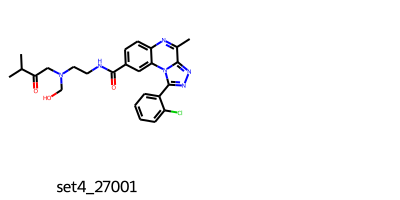

In [19]:
unstable_ligs=[]
unstable_lignames=[]
for i,l in enumerate(test_ligs):
    if("edge_JAN_PDE2_1345_"+l.GetProp("ID") in unstable_edges_names):
        unstable_ligs.append(l)
        unstable_lignames.append(l.GetProp("ID"))

Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(lig))for lig in unstable_ligs], legends=unstable_lignames,
                     subImgSize = (200,200), molsPerRow=2, maxMols=10)

# Analysis

----------------
Step 4. Analysis
------------------

`4a.` Firstly, let's process the calculated work values and estimate free energy differences.<br>
The `pmx analyse` program will integrate the dhdl.xvg files to obtain the forward and reverse work values.<br>
Subsequently, the Crooks fluctuation theorem and Jarzynski estimators will be applied to relate the work distributions to $\Delta G$

In [69]:
# # TI xvgs are incomplete and NPT took a long time
# not_finsished_edges_names=[
#     "edge_JAN_PDE2_1345_set4_26990",
#     "edge_JAN_PDE2_1345_set4_5596",
# #     "edge_JAN_PDE2_1345_set4_42807",
# #     "edge_JAN_PDE2_1345_set4_375984"
# ]

# finished_edges={e:fe.edges[e] for e in fe.edges if e not in not_finsished_edges_names}

In [102]:
# build a list of finished edges

finished_edges_names=[]

for edge in tqdm(fe.edges):
    fin=[False]*fe.replicas
    for r in range(1,fe.replicas+1):
        # ligand
        wp = 'water'
        analysispath = '{0}/analyse{1}'.format(fe._get_specific_path(edge=edge,wp=wp),r)
        create_folder(analysispath)
        stateApath = fe._get_specific_path(edge=edge,wp=wp,state='stateA',r=r,sim='transitions')
        stateBpath = fe._get_specific_path(edge=edge,wp=wp,state='stateB',r=r,sim='transitions')
        gA_w = glob.glob('{0}/*xvg'.format(stateApath))
        gB_w = glob.glob('{0}/*xvg'.format(stateBpath))

        # protein
        wp = 'protein'
        analysispath = '{0}/analyse{1}'.format(fe._get_specific_path(edge=edge,wp=wp),r)
        create_folder(analysispath)
        stateApath = fe._get_specific_path(edge=edge,wp=wp,state='stateA',r=r,sim='transitions')
        stateBpath = fe._get_specific_path(edge=edge,wp=wp,state='stateB',r=r,sim='transitions')
        gA_p = glob.glob('{0}/*xvg'.format(stateApath))
        gB_p = glob.glob('{0}/*xvg'.format(stateBpath))

        if(len(gA_w)>=80 and len(gB_w)>=80 and len(gA_p)>=80 and len(gB_p)>=80):
            fin[r-1]=True
    if(all(fin)):
        finished_edges_names.append(edge)

finished_edges={e:fe.edges[e] for e in finished_edges_names}
# print(finished_edges)
print(len(finished_edges))

100%|██████████| 100/100 [00:01<00:00, 79.17it/s]

100


In [103]:
#fe.run_analysis( bVerbose=True)

# excluded=["edge_JAN_PDE2_1345_JAN_PDE2_994"] # we don't have water for this one yet
# ana_edges={x: fe.edges[x] for x in fe.edges if x not in excluded}
# fe.run_analysis(edges=ana_edges, bLig=False, bProt=True, bVerbose=False)

# fe.run_analysis( bLig=False, bProt=True, bVerbose=False)
# fe.run_analysis( bLig=True, bProt=True, bVerbose=False, only_check_completition=True)
fe.run_analysis( bLig=True, bProt=True, bVerbose=False, n_processes=8, edges=finished_edges)
# fe.run_analysis( bLig=True, bProt=True, bVerbose=False, n_processes=8)

----------------
Running analysis
----------------
edge_JAN_PDE2_1345_set4_282631
edge_JAN_PDE2_1345_set4_190810
edge_JAN_PDE2_1345_set4_239358
edge_JAN_PDE2_1345_set4_73299
edge_JAN_PDE2_1345_set4_287375
edge_JAN_PDE2_1345_set4_200517
edge_JAN_PDE2_1345_set4_202115
edge_JAN_PDE2_1345_set4_48428
edge_JAN_PDE2_1345_set4_240260
edge_JAN_PDE2_1345_set4_72351
edge_JAN_PDE2_1345_set4_190881
edge_JAN_PDE2_1345_set4_282373
edge_JAN_PDE2_1345_set4_287282
edge_JAN_PDE2_1345_set4_72575
edge_JAN_PDE2_1345_set4_122493
edge_JAN_PDE2_1345_set4_190846
edge_JAN_PDE2_1345_set4_204566
edge_JAN_PDE2_1345_set4_71635
edge_JAN_PDE2_1345_set4_316545
edge_JAN_PDE2_1345_set4_48430
edge_JAN_PDE2_1345_set4_286342
edge_JAN_PDE2_1345_set4_121446
edge_JAN_PDE2_1345_set4_287270
edge_JAN_PDE2_1345_set4_189959
edge_JAN_PDE2_1345_set4_295198
edge_JAN_PDE2_1345_set4_72556
edge_JAN_PDE2_1345_set4_7479
edge_JAN_PDE2_1345_set4_204555
edge_JAN_PDE2_1345_set4_188327
edge_JAN_PDE2_1345_set4_189907
edge_JAN_PDE2_1345_set4_2402

`4b.` Finally, we can collect all the results into one data structure and investigate the outcome.<br>
Let's also set the number of replicas back to 3, because results from three repeats have been pre-calculated for this tutorial.<br>
Here, we read the $\Delta G$ values and calculate $\Delta\Delta G$.<br>
The calculated error reflects the statistical uncertainty and the variation between multiple calculation repeats.

In [104]:
fe.replicas = 3
fe.analysis_summary( edges=finished_edges )
# fe.analysis_summary()

In [105]:
fe.resultsAll

,val,err_analyt,err_boot,framesA,framesB
edge_JAN_PDE2_1345_set4_190810_water_1,8.970000,4.900000,2.940000,80.0,80.0
edge_JAN_PDE2_1345_set4_190810_protein_1,-12.750000,197.260000,3.460000,80.0,80.0
edge_JAN_PDE2_1345_set4_190810_water_2,12.940000,2.920000,2.840000,80.0,80.0
edge_JAN_PDE2_1345_set4_190810_protein_2,-9.370000,1271.560000,1.390000,80.0,80.0
edge_JAN_PDE2_1345_set4_190810_water_3,9.580000,3.480000,4.120000,80.0,80.0
...,...,...,...,...,...
edge_JAN_PDE2_1345_set4_186047_protein,-64.290000,3.558740,2.103344,NaN,NaN
edge_JAN_PDE2_1345_set4_204564_water,-92.953333,1.630796,1.549581,NaN,NaN
edge_JAN_PDE2_1345_set4_204564_protein,-109.213333,84.358606,3.971382,NaN,NaN
edge_JAN_PDE2_1345_set4_316732_water,75.976667,1.384904,1.398285,NaN,NaN


In [107]:
#fe.resultsSummary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fe.resultsAll)

                                                 val   err_analyt  err_boot  \
edge_JAN_PDE2_1345_set4_190810_water_1      8.970000     4.900000  2.940000   
edge_JAN_PDE2_1345_set4_190810_protein_1  -12.750000   197.260000  3.460000   
edge_JAN_PDE2_1345_set4_190810_water_2     12.940000     2.920000  2.840000   
edge_JAN_PDE2_1345_set4_190810_protein_2   -9.370000  1271.560000  1.390000   
edge_JAN_PDE2_1345_set4_190810_water_3      9.580000     3.480000  4.120000   
edge_JAN_PDE2_1345_set4_190810_protein_3   -9.100000    25.070000  5.340000   
edge_JAN_PDE2_1345_set4_72351_water_1       7.740000     2.260000  1.490000   
edge_JAN_PDE2_1345_set4_72351_protein_1     0.400000     3.120000  3.120000   
edge_JAN_PDE2_1345_set4_72351_water_2       8.160000     2.040000  1.660000   
edge_JAN_PDE2_1345_set4_72351_protein_2   -10.170000     7.110000  3.640000   
edge_JAN_PDE2_1345_set4_72351_water_3       5.940000     1.940000  2.000000   
edge_JAN_PDE2_1345_set4_72351_protein_3    -8.880000

In [108]:
#fe.resultsSummary
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fe.resultsSummary)

                                      val  err_analyt  err_boot
edge_JAN_PDE2_1345_set4_190810 -20.903333  427.078811  3.230266
edge_JAN_PDE2_1345_set4_72351  -13.496667    5.183751  3.398407
edge_JAN_PDE2_1345_set4_204566 -18.420000   12.483381  2.936315
edge_JAN_PDE2_1345_set4_189959 -12.856667   11.649619  2.289900
edge_JAN_PDE2_1345_set4_287375 -21.356667   15.660977  1.784139
edge_JAN_PDE2_1345_set4_287282 -23.933333    8.441491  5.522515
edge_JAN_PDE2_1345_set4_286342 -11.413333    8.853435  2.062158
edge_JAN_PDE2_1345_set4_188327 -19.096667   20.137829  4.120956
edge_JAN_PDE2_1345_set4_239358 -17.463333   46.703892  4.179377
edge_JAN_PDE2_1345_set4_190881 -18.356667  139.396768  5.336271
edge_JAN_PDE2_1345_set4_72575  -15.223333   50.312928  2.322145
edge_JAN_PDE2_1345_set4_121446 -22.996667   43.091977  2.119082
edge_JAN_PDE2_1345_set4_282631 -11.226667    6.439534  2.339477
edge_JAN_PDE2_1345_set4_240260 -21.173333   10.611068  3.667586
edge_JAN_PDE2_1345_set4_71635  -16.92000

In [109]:
def grid_mols_with_annotation(mols, labels, sub_img_size=(250,250), mols_per_row=10, title="", annotation_size=22, title_size=25, y_offset=-20):
    """Annotates a MolsToGridImage given a set of labels for each mol with better font size options and title"""
    
    img = Chem.Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=sub_img_size, maxMols=len(mols), returnPNG=False)
    
    fig, ax = plt.subplots(figsize=(40,40))
    plt.title(title, fontsize=title_size)
    text_pos = (sub_img_size[0]/2, sub_img_size[1]+y_offset)
    pos_ctr = 0
    plt.axis("off")
    for cmpd_text in labels:
        plt.annotate(cmpd_text, text_pos, fontsize=annotation_size, horizontalalignment='center')
        pos_ctr += 1
        text_pos = (text_pos[0]+sub_img_size[0], text_pos[1])
        if (pos_ctr % mols_per_row) == 0:
            text_pos = (sub_img_size[0]/2, text_pos[1] + sub_img_size[1])

    ax.imshow(img, origin="upper")

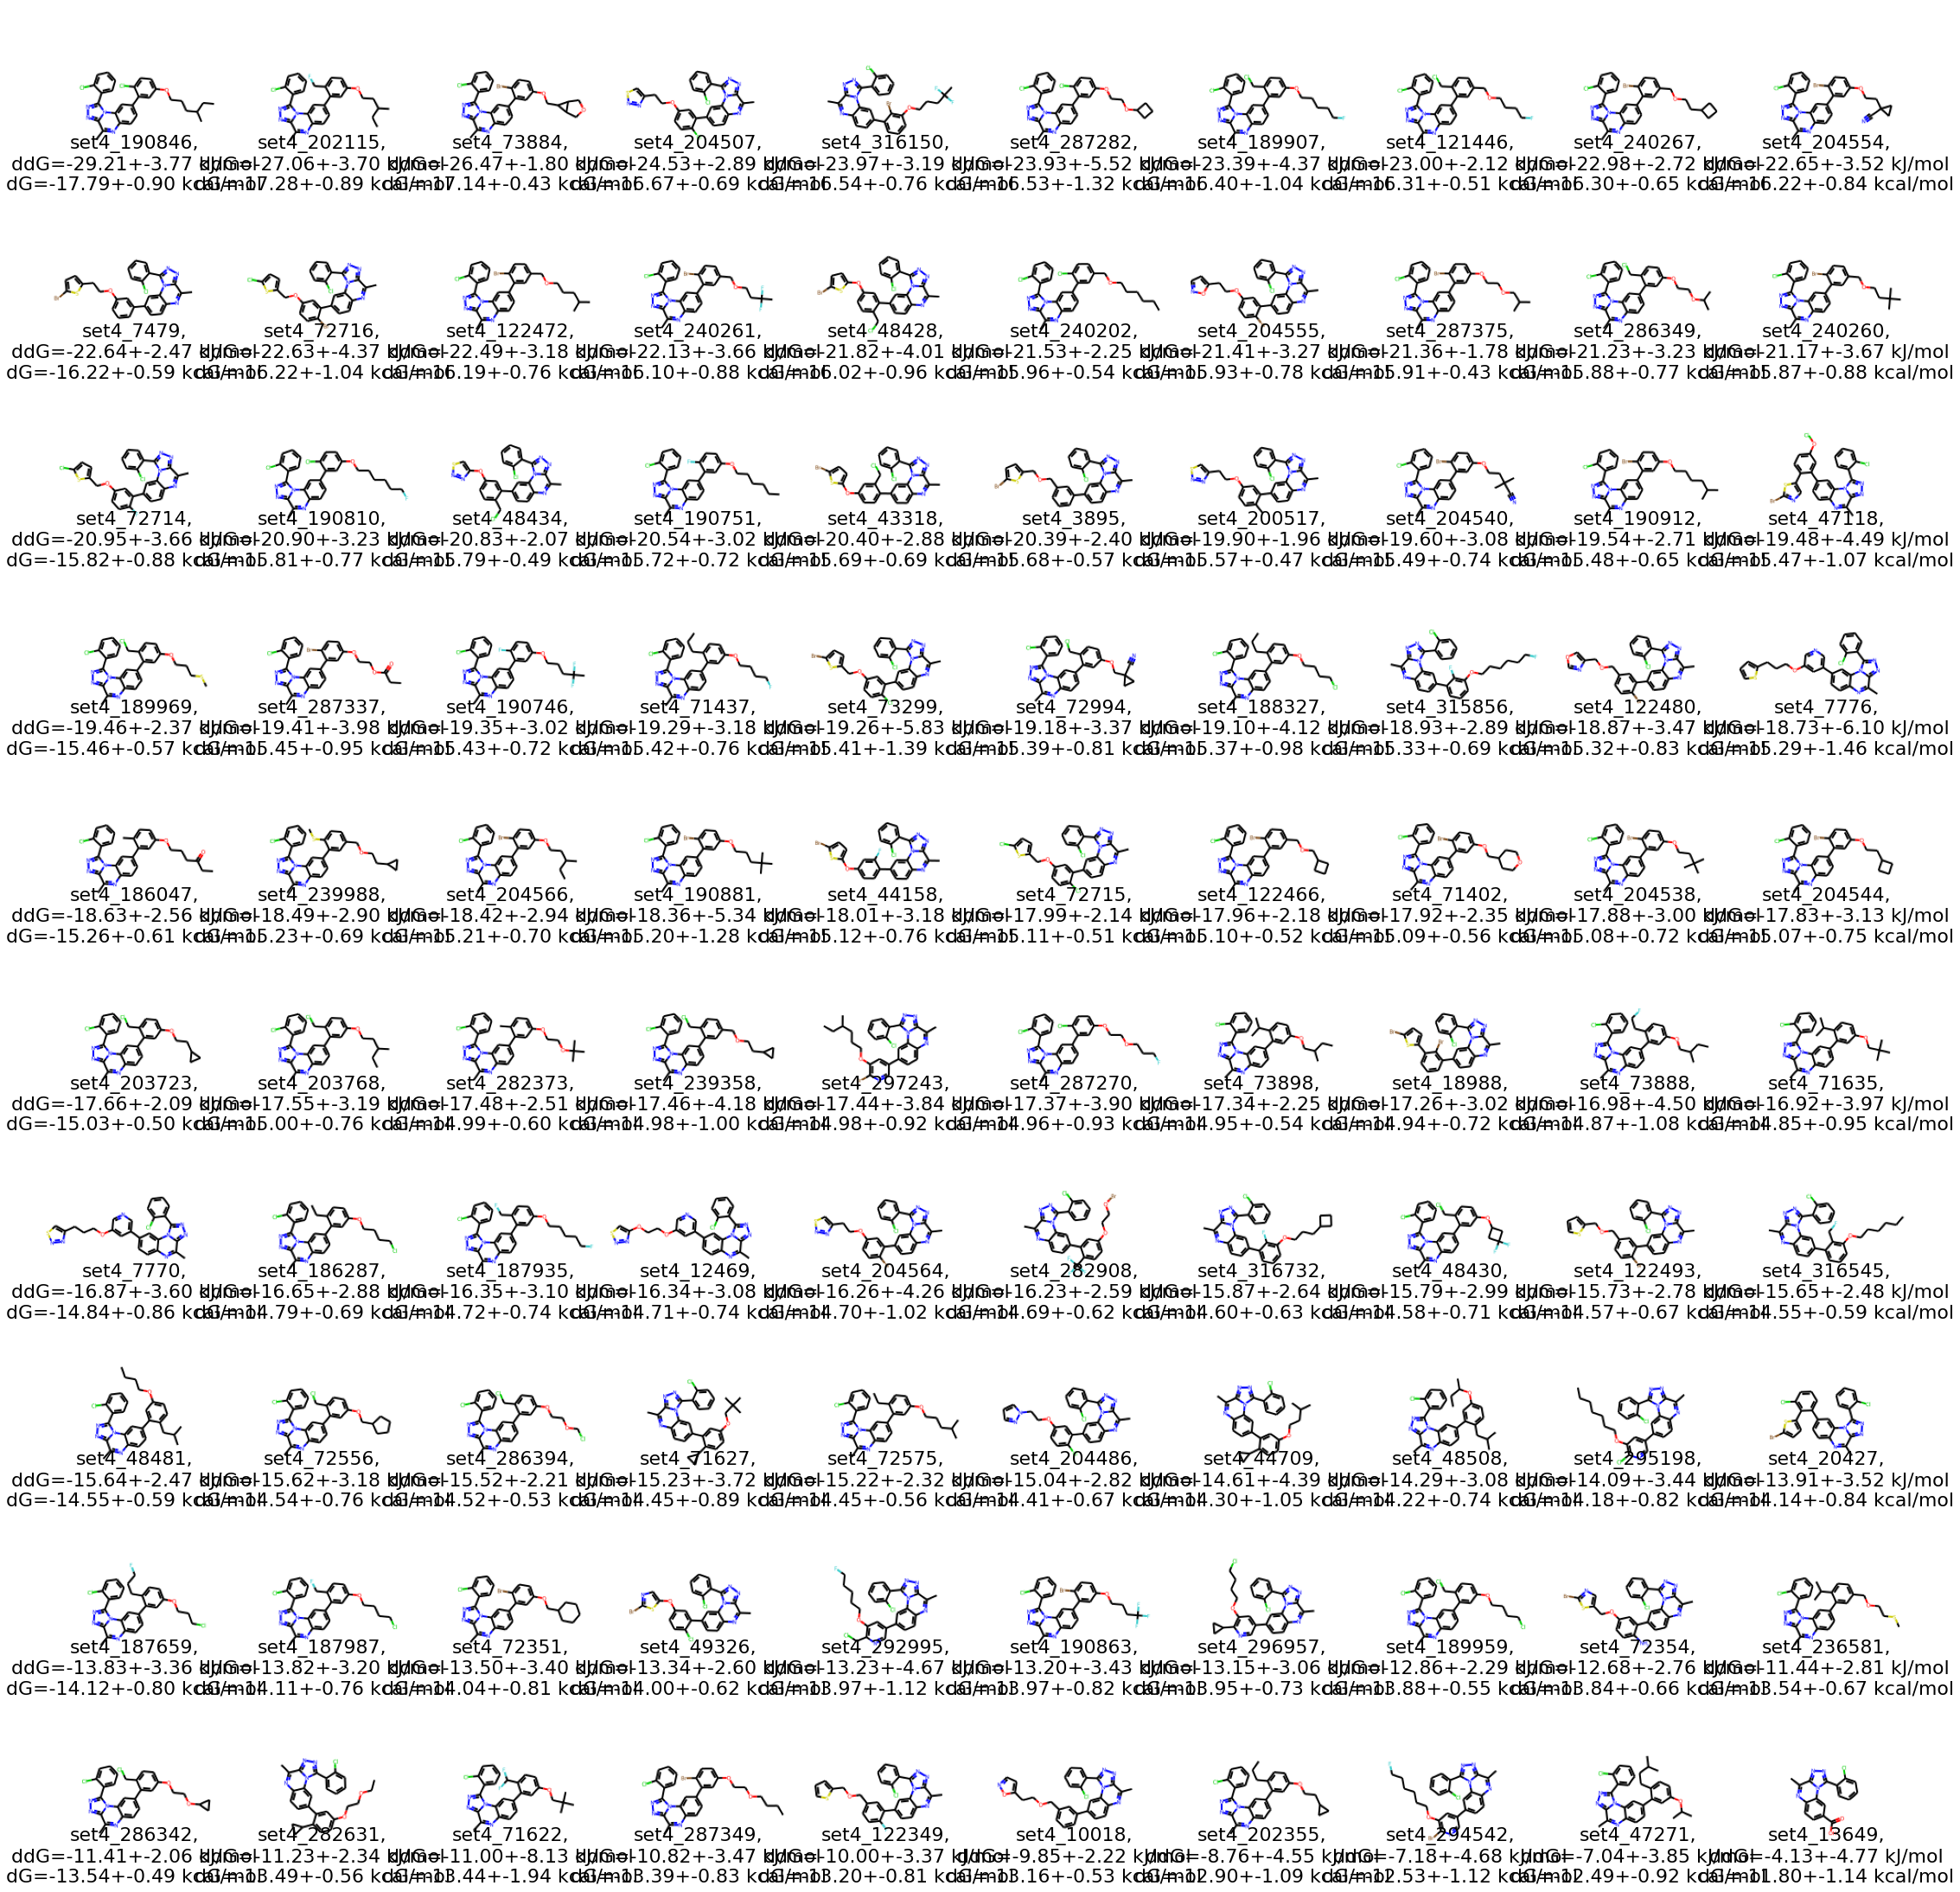

In [110]:
cutoff_ddg=-16

cal2J = 4.184
def lig_to_dG(lig):
    RT=0.001985875*300 #kcal/mol
    return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
red_dG=lig_to_dG(reference_lig)

tight_binders=[]
legends=[]
tight_dGs=[]
for i,l in enumerate(test_ligs):
    edge=f"edge_JAN_PDE2_1345_{l.GetProp('ID')}"
    if(edge in finished_edges):
        val=fe.resultsSummary.at[edge,'val']
        uncert=fe.resultsSummary.at[edge,'err_boot']
#         if(val<cutoff_ddg):
        tight_binders.append(Chem.MolFromSmiles(Chem.MolToSmiles(l)))
        legends.append(f"{l.GetProp('ID')},\nddG={val:.2f}+-{uncert:.2f} kJ/mol\ndG={fe.resultsSummary.loc[edge,'val']/cal2J + red_dG: .2f}+-{uncert/cal2J:.2f} kcal/mol")
        tight_dGs.append(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG)
order=np.argsort(tight_dGs)
            
# Draw.MolsToGridImage([tight_binders[i] for i in order],
#                      legends=[legends[i] for i in order],
#                      subImgSize = (200,200), molsPerRow=5, maxMols=101)

   
grid_mols_with_annotation([tight_binders[i] for i in order], [legends[i] for i in order],
                     sub_img_size =(200,200), mols_per_row=10, y_offset=-5)

In [111]:
print(len(tight_binders))

100


In [112]:
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull
@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

ordered_ligs_Rgroup_only=[]

core_smiles="c7(C)nc8ccccc8n8c(c6c(Cl)[cH][cH][cH][cH]6)nnc78"
core=Chem.MolFromSmiles(core_smiles)

with suppress_stdout_stderr():
    res,unmatched = rdRGD.RGroupDecompose([core], [tight_binders[i] for i in order], asSmiles=True)# print(unmatched)
if(len(unmatched)>0):
    raise()

for i,l in enumerate(res):
    new_l={}
    for rg in l:
        if rg=='Core':
            continue;
        if l[rg][:3]!='[H]':
            new_l[rg]=l[rg]
    if(len(new_l)==1):
        Rgroup_smi=new_l['R1']
        smi_params=Chem.rdmolfiles.SmilesParserParams()
        smi_params.removeHs=True
        Rgroup=Chem.AddHs(Chem.MolFromSmiles(Rgroup_smi))
        Rgroup_smi=Chem.MolToSmiles(Rgroup)
#         Rgroup_smi=Rgroup_smi.replace("[*:1]", "[*:R_2]")
#         Rgroup_smi=Rgroup_smi.replace("()", "")
        Rgroup=Chem.MolFromSmiles(Rgroup_smi, smi_params)

        for i in range(Rgroup.GetNumAtoms()):
            symb=Rgroup.GetAtomWithIdx(i).GetSymbol()
            if(symb=="*"):
                Rgroup.GetAtomWithIdx(i).SetProp("_displayLabel","R<sub>core</sub>")

        ordered_ligs_Rgroup_only.append(Chem.PropertyMol.PropertyMol(Rgroup))

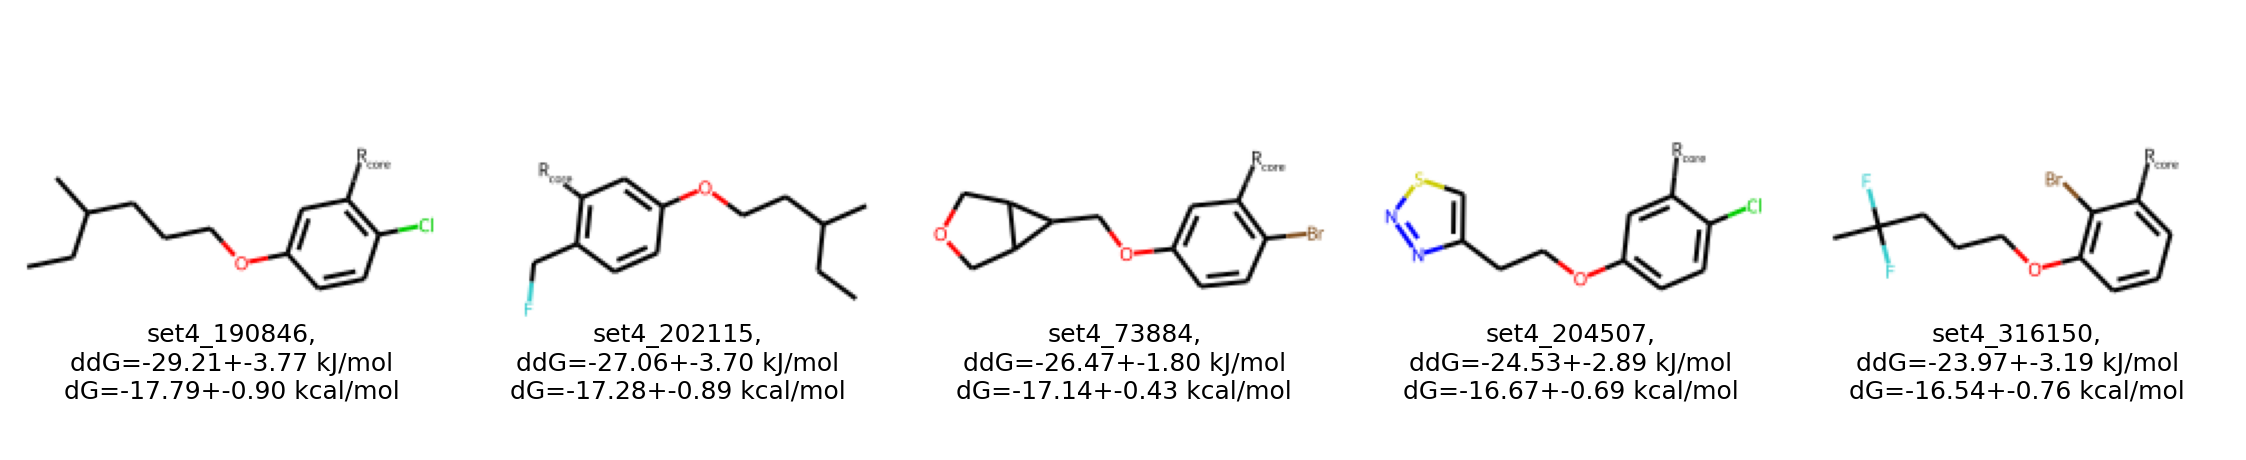

In [113]:
grid_mols_with_annotation(ordered_ligs_Rgroup_only[:5],
                 labels=[legends[i] for i in order[:5]],
                 sub_img_size = (200,200), mols_per_row=5, annotation_size=25, y_offset=-25)

### save preliminary results for finished ligands

In [95]:
# cal2J = 4.184
# def lig_to_dG(lig):
#     RT=0.001985875*300 #kcal/mol
#     return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
# red_dG=lig_to_dG(reference_lig)

# save_ligs=[]
# for edge in fe.resultsSummary.index:
#     ligname=edge[19:]
#     for lig in test_ligs:
#         if lig.GetProp('ID')==ligname:
#             lig.SetProp("ddG", str(fe.resultsSummary.loc[edge,'val']/cal2J) ) # kcal/mol
#             lig.SetProp("dG", str(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG) ) # kcal/mol
#             lig.SetProp("dG_err", str(fe.resultsSummary.loc[edge,'err_boot']/cal2J) )  # kcal/mol
#             save_ligs.append(PropertyMol.PropertyMol(lig))
            
# print(len(save_ligs))

# fname="finished_ligs_prelim.pickle"

# with  open( fname, "wb" ) as f:
#     pickle.dump(save_ligs, f)

91


# save the stable ligs as a pickle for training

In [114]:
cal2J = 4.184
def lig_to_dG(lig):
    RT=0.001985875*300 #kcal/mol
    return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
red_dG=lig_to_dG(reference_lig)

save_ligs=[]
for edge in fe.resultsSummary.index:
    ligname=edge[19:]
    for lig in test_ligs:
        if lig.GetProp('ID')==ligname:
            lig.SetProp("ddG", str(fe.resultsSummary.loc[edge,'val']/cal2J) ) # kcal/mol
            lig.SetProp("dG", str(fe.resultsSummary.loc[edge,'val']/cal2J + red_dG) ) # kcal/mol
            lig.SetProp("dG_err", str(fe.resultsSummary.loc[edge,'err_boot']/cal2J) )  # kcal/mol
            save_ligs.append(PropertyMol.PropertyMol(lig))
            
print(len(save_ligs))

fname="stable_ligs.pickle"

with  open( fname, "wb" ) as f:
    pickle.dump(save_ligs, f)

100


In [84]:
# cal2J = 4.184
# def lig_to_dG(lig):
#     RT=0.001985875*300 #kcal/mol
#     return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))

# print(f"ref lig dG: {lig_to_dG(reference_lig)} kcal/mol")

In [85]:
# # fix the saved ligands' dG values
# fname="stable_ligs.pickle"
# with open(fname, 'rb') as f:
#     save_ligs = pickle.load(f)
    
# red_dG=lig_to_dG(reference_lig)
    
# for i,lig in enumerate(save_ligs):
#     ddG=float(lig.GetProp("ddG"))
#     lig.SetProp("dG", str(ddG + red_dG) ) # kcal/mol
#     save_ligs[i]=PropertyMol.PropertyMol(lig)
    
# fname="stable_ligs_fixed_dG.pickle"
# with  open( fname, "wb" ) as f:
#     pickle.dump(save_ligs, f)

# Also write dG value into the big 34K lig DB pickle file

In [115]:
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step3_dG.pickle"
with open(all_ligs_db_file, 'rb') as f:
    ligs_set4f = pickle.load(f)
    
with open("stable_ligs.pickle", 'rb') as f:
# with open("finished_ligs_prelim.pickle", 'rb') as f:
    step_known_ligs = pickle.load(f)

known_lig_idxs_in_set4f=[]
known_lig_idxs_in_step=[]
known_lig_idxs=[l.GetProp('ID') for l in step_known_ligs]
for i,lig in enumerate(ligs_set4f):
    if(lig.GetProp('ID') in known_lig_idxs):
        known_lig_idxs_in_set4f.append(i)
        known_lig_idxs_in_step.append(known_lig_idxs.index(lig.GetProp('ID')))

In [116]:
print(known_lig_idxs_in_step)
print(known_lig_idxs_in_set4f)

[48, 18, 93, 65, 92, 50, 33, 58, 53, 75, 81, 35, 70, 68, 27, 25, 67, 42, 90, 74, 78, 57, 64, 62, 14, 1, 60, 15, 10, 61, 38, 63, 72, 23, 47, 51, 86, 11, 52, 36, 32, 94, 21, 97, 59, 45, 87, 46, 7, 31, 3, 73, 71, 69, 0, 28, 82, 9, 95, 16, 20, 84, 66, 55, 37, 39, 44, 76, 56, 41, 26, 98, 2, 34, 8, 40, 43, 13, 88, 22, 24, 12, 80, 6, 85, 77, 91, 5, 19, 54, 4, 49, 30, 29, 83, 96, 79, 89, 17, 99]
[1713, 3231, 3354, 3359, 4164, 5016, 5261, 8083, 8774, 11087, 11357, 11823, 12698, 12732, 12942, 12944, 12948, 12980, 12984, 13266, 13854, 13868, 13905, 13910, 13912, 14040, 14042, 14066, 14073, 14086, 14087, 14088, 14126, 14165, 14264, 14268, 14272, 15190, 15320, 15405, 15409, 15414, 15420, 20810, 20868, 20976, 20992, 21000, 21012, 21022, 21030, 21031, 21072, 21074, 21095, 21104, 21114, 21123, 21129, 21170, 21404, 21418, 21454, 21466, 21556, 21566, 21587, 21589, 21592, 21598, 21599, 21601, 21602, 22389, 22481, 22498, 22543, 22562, 22563, 22565, 26910, 26973, 27003, 27130, 27131, 27137, 27200, 27207, 2

In [117]:
for i in range(len(known_lig_idxs_in_step)):
    idx_step=known_lig_idxs_in_step[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step0, idx_set4f)
    
    old_lig=step_known_ligs[idx_step]
    new_lig=ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)

fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step4_dG.pickle"
# fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step4_dG_prelim.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(ligs_set4f, f)
    
del ligs_set4f

In [118]:
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step3_dG.pickle"

with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)
    
    
for i in range(len(known_lig_idxs_in_step)):
    idx_step=known_lig_idxs_in_step[i]
    idx_set4f=known_lig_idxs_in_set4f[i]
    
    #print(idx_step, idx_set4f)
    
    old_lig=step_known_ligs[idx_step]
    new_lig=no_core_ligs_set4f[idx_set4f]
    

    new_lig.SetProp("ddG", old_lig.GetProp("ddG") ) # kcal/mol
    new_lig.SetProp("dG", old_lig.GetProp("dG") ) # kcal/mol
    new_lig.SetProp("dG_err", old_lig.GetProp("dG_err") ) # kcal/mol
    
    no_core_ligs_set4f[idx_set4f]=PropertyMol.PropertyMol(new_lig)
    
fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step4_dG.pickle"
# fname=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step4_dG_prelim.pickle"
with  open( fname, "wb" ) as f:
    pickle.dump(no_core_ligs_set4f, f)
    
del no_core_ligs_set4f